In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Definimos la clase para manejar los datasets.
class MiDataset(Dataset):
    #Constructor de la clase. Carga los archivos CSV a tensores PyTorch
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        # Extraer las primeras 5 columnas como entradas (medidas antropométricas y objetivos de paso)
        self.inputs = torch.tensor(self.data.iloc[:, :5].values, dtype=torch.float32)
        # Extraer las siguientes 30 columnas como salidas (15 pares de coordenadas X, Y)
        self.outputs = torch.tensor(self.data.iloc[:, 5:].values, dtype=torch.float32)

    def __len__(self):
        ##Devuelve el número total de muestras en el dataset.
        return len(self.data)
    def __getitem__(self, idx):
        ##Permite acceder a una muestra específica del dataset.
                ##Parámetro:
        ##- idx (int): Índice de la muestra a recuperar.
                ##Retorna:
        ##- Un par (input, output) correspondiente a la fila idx del CSV.
        return self.inputs[idx], self.outputs[idx]

In [ ]:
# Definimos la red neuronal
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 32),  # Capa de entrada
            nn.ReLU(),
            nn.Linear(32, 64),  # Capa oculta
            nn.ReLU(),
            nn.Linear(64, 128),  # Capa oculta
            nn.ReLU(),
            nn.Linear(128, 256),  # Capa oculta
            nn.ReLU(),
            nn.Linear(256, 30)  # Capa de salida con 30 valores
        )

    def forward(self, x):
        return self.model(x)

# Crear el modelo
modelo = MLP()

In [ ]:
# Definimos la función de pérdida y el optimizador
criterio = nn.MSELoss()  # MSE = Mean Squared Error
optimizador = optim.Adam(modelo.parameters(), lr=0.001)  # Tasa de aprendizaje de 0.001

In [ ]:
# Cargamos de los datos para entrenamiento y validación.
train_dataset = MiDataset("datos_train.csv")
valid_dataset = MiDataset("datos_valid.csv")
# Creamos un DataLoader para manejar los datos en batches de 32 muestras
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Recorremos los datos para asegurar que está todo ok
for batch_inputs, batch_outputs in train_loader:
    print("Entradas del batch:", batch_inputs.shape)  # Debería ser [32, 5] si hay 32 muestras
    print("Salidas del batch:", batch_outputs.shape)  # Debería ser [32, 30] para los 15 pares (X, Y)
    break  # Solo mostramos el primer batch

Entradas del batch: torch.Size([32, 5])
Salidas del batch: torch.Size([32, 30])


Época 1: MSE entrenamiento: 54045.5417, RMSE entrenamiento: 232.4770, MSE validación: 10443.6576, RMSE validación: 102.1942
  Error Porcentual entrenamiento: 27.75%
  Error Porcentual validación: 12.26%
Entrenamiento finalizado. Se ha guardado el mejor modelo.
Época 2: MSE entrenamiento: 31391.6976, RMSE entrenamiento: 177.1770, MSE validación: 1671.8347, RMSE validación: 40.8881
  Error Porcentual entrenamiento: 21.15%
  Error Porcentual validación: 4.91%
Entrenamiento finalizado. Se ha guardado el mejor modelo.
Época 3: MSE entrenamiento: 4031.5810, RMSE entrenamiento: 63.4947, MSE validación: 697.8446, RMSE validación: 26.4167
  Error Porcentual entrenamiento: 7.58%
  Error Porcentual validación: 3.17%
Entrenamiento finalizado. Se ha guardado el mejor modelo.
Época 4: MSE entrenamiento: 2599.4320, RMSE entrenamiento: 50.9846, MSE validación: 667.5505, RMSE validación: 25.8370
  Error Porcentual entrenamiento: 6.09%
  Error Porcentual validación: 3.10%
Entrenamiento finalizado. Se ha

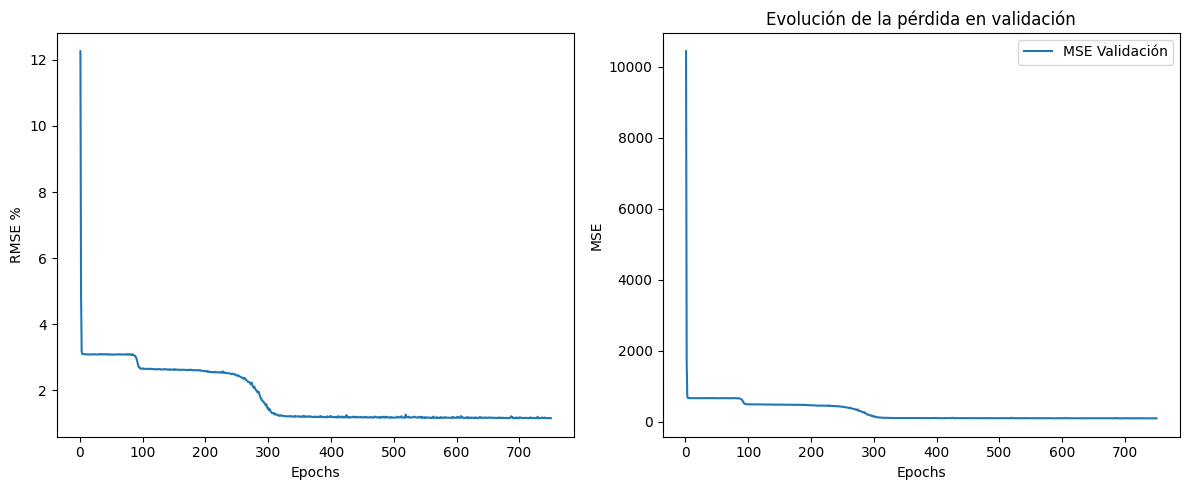

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Configuración de entrenamiento y validación
num_epochs = 750 # 750 épocas
mejor_loss_valid = float("inf")
paciencia_contador = 0  # Contador para añadir early stopping
paciencia = 10  # Límite para detener el entrenamiento si la pérdida de validación no mejora
epochs = []  # Lista para almacenar los números de época
# Listas para almacenar métricas
loss_valid_hist = []
error_porcentual_valid_hist = []

for epoch in range(num_epochs):
    modelo.train()  # Modo entrenamiento
    total_loss_train = 0
    total_rmse_train = 0
    total_salida_train = 0  # Para calcular el valor promedio de la salida (batch_outputs)

    for batch_inputs, batch_outputs in train_loader:
        # Forward: calcular predicciones
        predicciones = modelo(batch_inputs)

        # Calcular la pérdida (MSE)
        loss = criterio(predicciones, batch_outputs)

        # Backpropagation y optimización
        optimizador.zero_grad()
        loss.backward()
        optimizador.step()

        # Acumulamos las pérdidas de todos los batches
        total_loss_train += loss.item()

        # Sumar los valores reales para obtener su promedio
        total_salida_train += batch_outputs.sum().item()

    # Validación
    modelo.eval()  # Modo evaluación
    total_loss_valid = 0
    total_rmse_valid = 0
    total_salida_valid = 0  # Para calcular el valor promedio de la salida (batch_outputs)

    with torch.no_grad():  # No calcular gradientes en validación
        for batch_inputs, batch_outputs in valid_loader:
            predicciones = modelo(batch_inputs)
            loss = criterio(predicciones, batch_outputs)
            # Acumulamos las pérdidas de todos los batches
            total_loss_valid += loss.item()

            # Sumar los valores reales para obtener su promedio
            total_salida_valid += batch_outputs.sum().item()

    # Calcular RMSE para cada época completa del entrenamiento
    total_rmse_train = torch.sqrt(torch.tensor(total_loss_train)).item()
    # Calcular RMSE para cad época completa de la validación
    total_rmse_valid = torch.sqrt(torch.tensor(total_loss_valid)).item()

    # Promedio de pérdidas y RMSE
    #avg_loss_train = total_loss_train / len(train_loader.dataset)
    #avg_rmse_train = total_rmse_train / len(train_loader.dataset)
    #avg_loss_valid = total_loss_valid / len(valid_loader.dataset)
    #avg_rmse_valid = total_rmse_valid / len(valid_loader.dataset)

    # Promedio de las salidas reales (para cálculo de porcentaje)
    avg_salida_train = total_salida_train / len(train_loader.dataset)
    avg_salida_valid = total_salida_valid / len(valid_loader.dataset)

    # Cálculo del error porcentual
    error_porcentual_train = (total_rmse_train / avg_salida_train) * 100
    error_porcentual_valid = (total_rmse_valid / avg_salida_valid) * 100

     # Guardar métricas para graficar
    loss_valid_hist.append(total_loss_valid)
    error_porcentual_valid_hist.append(error_porcentual_valid)
    epochs.append(epoch + 1)  # Guardar la época actual

    # Imprimir los resultados
    print(f"Época {epoch+1}: MSE entrenamiento: {total_loss_train:.4f}, RMSE entrenamiento: {total_rmse_train:.4f}, "
          f"MSE validación: {total_loss_valid:.4f}, RMSE validación: {total_rmse_valid:.4f}")
    print(f"  Error Porcentual entrenamiento: {error_porcentual_train:.2f}%")
    print(f"  Error Porcentual validación: {error_porcentual_valid:.2f}%")

    # # Early stopping: si la pérdida en validación no mejora, contamos épocas sin mejora
    # if total_loss_valid < mejor_loss_valid:
    #     mejor_loss_valid = total_loss_valid
    #     paciencia_contador = 0
    torch.save(modelo.state_dict(), "NN.pth")  # Guardamos el mejor modelo
    # else:
    #     paciencia_contador += 1
    #     if paciencia_contador >= paciencia:
    #         print(f"Deteniendo entrenamiento temprano en la época {epoch} por falta de mejora en validación.")
    #         break  # Salimos del bucle

    # # Cargar el mejor modelo encontrado
    #modelo.load_state_dict(torch.load("NN.pth"))
    print("Entrenamiento finalizado. Se ha guardado el mejor modelo.")

    # Mostrar la pérdida cada 10 épocas
    #if epoch % 10 == 0:
     #   print(f"Época {epoch}, Pérdida: {total_loss_train / len(train_loader.dataset)}")

    # Graficamos la evolución del error de validación
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, error_porcentual_valid_hist, label='Error % Validación')
plt.xlabel('Epochs')
plt.ylabel('RMSE %')
#plt.title('Evolución del Error Porcentual en validación')
#plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_valid_hist, label='MSE Validación')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Evolución de la pérdida en validación')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

# Asegurarnos de que el modelo está cargado correctamente
modelo = MLP()
modelo.load_state_dict(torch.load("NN.pth"))  # Cargamos el modelo entrenado
modelo.eval()  # Modo evaluación

# Cargamos los datos de test
datos_test = pd.read_csv("datos_test.csv", header=None)

# Separamos las entradas y salidas
entradas_test = torch.tensor(datos_test.iloc[:, :5].values, dtype=torch.float32)
salidas_ideales = torch.tensor(datos_test.iloc[:, 5:].values, dtype=torch.float32)

# Inicializamos el cálculo del RMSE total
total_rmse_pares = 0
total_rmse_impares = 0
#total_rmse = 0
# Listas de índices pares e impares (0-indexed)
indices_pares = list(range(1, 30, 2))   # 2ª, 4ª, 6ª, ..., 30ª salida
indices_impares = list(range(0, 30, 2)) # 1ª, 3ª, 5ª, ..., 29ª salida
rmse_pares_muestras = []
rmse_impares_muestras = []

diferencia_promedio=torch.zeros_like(salidas_ideales[0])
total_muestras = len(entradas_test)
resultados = []  # Lista para almacenar los resultados
# errores_rmse_porcentual = []
# total_mse = 0
# rmse_promedio2=0

rmse_min_imp = float("inf")
rmse_max_imp = float("-inf")
rmse_min_par = float("inf")
rmse_max_par = float("-inf")
indice_rmse_impares_min = -1
indice_rmse_impares_max = -1
indice_rmse_pares_min = -1
indice_rmse_pares_max = -1

# Predicciones y cálculo del RMSE
for i in range(total_muestras):
    entrada = entradas_test[i].unsqueeze(0)
    salida_ideal = salidas_ideales[i].squeeze(0)
    # Obtener la predicción
    salida_predicha = modelo(entrada).detach().squeeze(0)
    diferencias = salida_predicha - salida_ideal
    print(f"Diferencias: {diferencias}")
    diferencia_promedio += diferencias

    # # Calcular el RMSE
    # mse_loss = nn.MSELoss()(salida_predicha, salida_ideal)
    # rmse = torch.sqrt(mse_loss).item()
    # total_rmse += rmse
    # total_mse += mse_loss

    # # Calcular el error porcentual RMSE de cada muestra
    # promedio_salida_ideal = salida_ideal.mean().item()  # Promedio de la salida ideal para esta muestra
    # error_rmse_porcentual = (rmse / promedio_salida_ideal) * 100 if promedio_salida_ideal != 0 else 0

    # RMSE Parcial (pares e impares)
    salida_pred_pares = salida_predicha[indices_pares]
    salida_ideal_pares = salida_ideal[indices_pares]
    rmse_pares = torch.sqrt(nn.MSELoss()(salida_pred_pares, salida_ideal_pares)).item()

    salida_pred_impares = salida_predicha[indices_impares]
    salida_ideal_impares = salida_ideal[indices_impares]
    rmse_impares = torch.sqrt(nn.MSELoss()(salida_pred_impares, salida_ideal_impares)).item()

    total_rmse_pares += rmse_pares
    total_rmse_impares += rmse_impares
    rmse_pares_muestras.append(rmse_pares)
    rmse_impares_muestras.append(rmse_impares)

    # Verificar y actualizar mínimos y máximos
    if rmse_impares < rmse_min_imp:
        rmse_min_imp = rmse_impares
        indice_rmse_impares_min = i
    if rmse_impares > rmse_max_imp:
        rmse_max_imp = rmse_impares
        indice_rmse_impares_max = i
    if rmse_pares < rmse_min_par:
        rmse_min_par = rmse_pares
        indice_rmse_pares_min = i
    if rmse_pares > rmse_max_par:
        rmse_max_par = rmse_pares
        indice_rmse_pares_max = i

    # # Guardar el error RMSE en porcentaje en la lista
    # errores_rmse_porcentual.append(error_rmse_porcentual)

    # Guardar los datos en una lista
    fila = entrada.squeeze(0).tolist() + salida_predicha.tolist()  # Concatenamos correctamente
    resultados.append(fila)  # Añadimos la fila a la lista
    # Imprimir las salidas ideales vs las predicciones
    print(f"Entrada {i+1}: {entrada}")
    print(f"  Salida Ideal: {salida_ideal}")
    print(f"  Salida Predicha: {salida_predicha.squeeze()}")
    print(f"  RMSE percentual: {rmse_impares:.4f}")
    print(f"  RMSE angular: {rmse_pares:.4f} grados")
    print("-" * 50)

rmse_promedio_pares = total_rmse_pares / total_muestras
rmse_promedio_impares = total_rmse_impares / total_muestras
std_rmse_pares = np.std(rmse_pares_muestras)
std_rmse_impares = np.std(rmse_impares_muestras)


# # Calcular el RMSE promedio global
# rmse_promedio = total_rmse / total_muestras
# print(f"\nRMSE Promedio Global: {rmse_promedio:.4f}")
# diferencia_promedio = torch.tensor(diferencia_promedio) / total_muestras
# # Calcular el promedio global de las salidas ideales
# promedio_salida_ideal_global = salidas_ideales.mean().item()

# # Calcular el error RMSE promedio en porcentaje global
# rmse_porcentual_promedio = (rmse_promedio / promedio_salida_ideal_global) * 100
# print(f"Error Promedio RMSE en % (Global): {rmse_porcentual_promedio:.2f}%")
# print(f"Diferencia promedio: {diferencia_promedio}")

# Crear un DataFrame con las entradas y predicciones
columnas_entrada = [f"Entrada_{i+1}" for i in range(5)]
columnas_salida = [f"Salida_Predicha_{i+1}" for i in range(30)]
df_resultados = pd.DataFrame(resultados, columns=columnas_entrada + columnas_salida)
# Mostrar valores extremos al final
print(f"RMSE percentual promedio: {rmse_promedio_impares:.2f}")
print(f"Desviación percentual: {std_rmse_impares:.2f}")
print(f"\n🔹 RMSE Mínimo Percentual: {rmse_min_imp:.2f} en la muestra {indice_rmse_impares_min+1}")
print(f"🔹 RMSE Máximo Percentual: {rmse_max_imp:.2f} en la muestra {indice_rmse_impares_max+1}")
print(f"RMSE angular promedio: {rmse_promedio_pares:.2f}")
print(f"Desviación angular: {std_rmse_pares:.2f}")
print(f"\n🔹 RMSE Mínimo Angular: {rmse_min_par:.2f} grados en la muestra {indice_rmse_pares_min+1}")
print(f"🔹 RMSE Máximo Angular: {rmse_max_par:.2f} grados en la muestra {indice_rmse_pares_max+1}")
# Guardar en un CSV
df_resultados.to_csv("datos_prediccion.csv", index=False)
print("📂 Predicciones guardadas en 'datos_prediccion.csv'")

Diferencias: tensor([-2.3751e-04,  3.4244e+00,  4.2373e+00,  2.1978e+00,  7.3447e-01,
         4.7317e+00, -1.5053e-02,  4.2255e+00, -3.4622e-01,  4.2210e+00,
         1.5543e-01,  5.2810e+00,  3.1869e-01,  5.2051e+00, -1.1514e-02,
         5.4132e+00,  1.9790e+00,  4.0052e+00, -1.1414e+00,  3.5731e+00,
        -1.3441e-01,  7.1833e+00,  1.9532e+00,  2.9279e+00,  3.9507e-03,
        -1.4925e+00, -6.7908e+00, -5.9390e-01,  1.5117e+00, -1.8880e+00])
Entrada 1: tensor([[0.4023, 0.3749, 0.1443, 0.3676, 0.0759]])
  Salida Ideal: tensor([ 0.0000e+00,  2.3156e+01,  5.8000e+01,  4.6065e+00,  9.0000e+01,
         2.7329e+01,  0.0000e+00,  7.4620e+00,  1.0000e+01,  6.0787e+00,
         4.0000e+01,  4.4688e+00,  8.2000e+01,  4.6680e+01,  0.0000e+00,
         1.8930e+00,  6.0000e+00, -3.2869e-02,  6.4000e+01,  1.2878e+01,
         8.0000e+01, -7.2097e-01,  8.7000e+01,  7.7694e+00,  0.0000e+00,
         1.9295e-01,  5.0000e+01,  3.5141e+00,  9.1000e+01,  1.3091e-01])
  Salida Predicha: tensor([-2.3

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import time
import numpy as np

# Asegurarnos de que el modelo está cargado correctamente
modelo = MLP()
modelo.load_state_dict(torch.load("NN.pth"))  # Cargamos el modelo entrenado
modelo.eval()  # Modo evaluación

# Cargamos los datos de test
datos = pd.read_csv("datos_input_Vicon.csv", header=None)

# Separamos las entradas y salidas
entradas = torch.tensor(datos.iloc[:, :5].values, dtype=torch.float32)
total_muestras = len(entradas)
resultado = []
tiempos = []
# Predicciones
for i in range(total_muestras):
    entrada = entradas[i].unsqueeze(0)
    inicio = time.time()
    salida = modelo(entrada).detach().squeeze(0)
    fin = time.time()
    tiempos.append(fin - inicio)
    # Guardar los datos en una lista
    fila = entrada.squeeze(0).tolist() + salida.tolist()  # Concatenamos correctamente
    resultado.append(fila)  # Añadimos la fila a la lista

tiempo_medio = np.mean(tiempos)
tiempo_std = np.std(tiempos)
print(f"⏱️ Tiempo medio por iteración: {tiempo_medio*1000:.4f} ms")
print(f"📊 Desviación estándar: {tiempo_std*1000:.4f} ms")
    # Imprimir las salidas ideales vs las predicciones
columnas_entrad = [f"Entrada_{i+1}" for i in range(5)]
columnas_salid = [f"Salida_Predicha_{i+1}" for i in range(30)]
df_resultado = pd.DataFrame(resultado, columns=columnas_entrad + columnas_salid)
# Guardar en un CSV
df_resultado.to_csv("datos_prediccion_Vicon.csv", index=False)
print("📂 Predicciones guardadas en 'datos_prediccion_Vicon.csv'")

⏱️ Tiempo medio por iteración: 0.4142 ms
📊 Desviación estándar: 2.7640 ms
📂 Predicciones guardadas en 'datos_prediccion_Vicon.csv'
